In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# --- Settings ---
train_dataset_dir = 'dataset/'
width, height = 224, 224
target_size = (width, height)
input_shape = (width, height, 3)
BATCH_SIZE = 16
VAL_BATCH_SIZE = 8
EPOCHS = 50

In [3]:
# Preprocessing function for Xception
def preprocessing_function(img):
    return tf.keras.applications.xception.preprocess_input(img)

In [4]:
# --- Data generators ---
def image_data_generator():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=30,
        shear_range=0.3,
        zoom_range=0.3,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        validation_split=0.2,
        preprocessing_function=preprocessing_function
    )

    train_generator = train_datagen.flow_from_directory(
        train_dataset_dir,
        target_size=target_size,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dataset_dir,
        target_size=target_size,
        color_mode='rgb',
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False  # use False for evaluation/predictions consistency
    )

    # build a stable index->class mapping and return it too
    class_indices = train_generator.class_indices  # name -> index
    index_to_class = {v: k for k, v in class_indices.items()}

    return train_generator, validation_generator, index_to_class

train_generator, validation_generator, index_to_class = image_data_generator()
print("Index->Class mapping:", index_to_class)

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Index->Class mapping: {0: 'Anthracnose', 1: 'Bacterial Canker', 2: 'Cutting Weevil', 3: 'Die Back', 4: 'Gall Midge', 5: 'Healthy', 6: 'Powdery Mildew', 7: 'Sooty Mould'}


In [5]:
# --- Model builder ---
def disease_detector_pretrained(input_shape=input_shape, num_classes=None):
    if num_classes is None:
        raise ValueError("num_classes must be provided")

    # load base with explicit input shape (so weights and conv shapes match)
    base_model = tf.keras.applications.Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # freeze the base

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)  # frozen base -> training=False

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

num_classes = len(index_to_class)
model = disease_detector_pretrained(num_classes=num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [7]:
# Compile - note: Precision/Recall are included but may be binary-oriented.
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        # You can keep Precision/Recall but for multiclass prefer using sklearn after predictions.
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


In [8]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
]

In [8]:
# Fit
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_steps = max(1, validation_generator.samples // validation_generator.batch_size),
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
200/200 [==============================] - 164s 809ms/step - loss: 0.7428 - categorical_accuracy: 0.7434 - precision: 0.8367 - recall: 0.6675 - auc: 0.9588 - val_loss: 0.2580 - val_categorical_accuracy: 0.9075 - val_precision: 0.9285 - val_recall: 0.8925 - val_auc: 0.9952
Epoch 2/50
200/200 [==============================] - 161s 806ms/step - loss: 0.3098 - categorical_accuracy: 0.8934 - precision: 0.9144 - recall: 0.8750 - auc: 0.9916 - val_loss: 0.2175 - val_categorical_accuracy: 0.9212 - val_precision: 0.9306 - val_recall: 0.9050 - val_auc: 0.9959
Epoch 3/50
200/200 [==============================] - 160s 802ms/step - loss: 0.2567 - categorical_accuracy: 0.9181 - precision: 0.9291 - recall: 0.9044 - auc: 0.9928 - val_loss: 0.2822 - val_categorical_accuracy: 0.9225 - val_precision: 0.9299 - val_recall: 0.9125 - val_auc: 0.9884
Epoch 4/50
200/200 [==============================] - 159s 793ms/step - loss: 0.2444 - categorical_accuracy: 0.9197 - precision: 0.9333 - recall: 0.

In [9]:
# Ensure model directory exists and save (overwrite if exists)
os.makedirs('models', exist_ok=True)
model.save('models/disease-detection.h5', overwrite=True)

c:\Users\User\anaconda3\envs\newenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


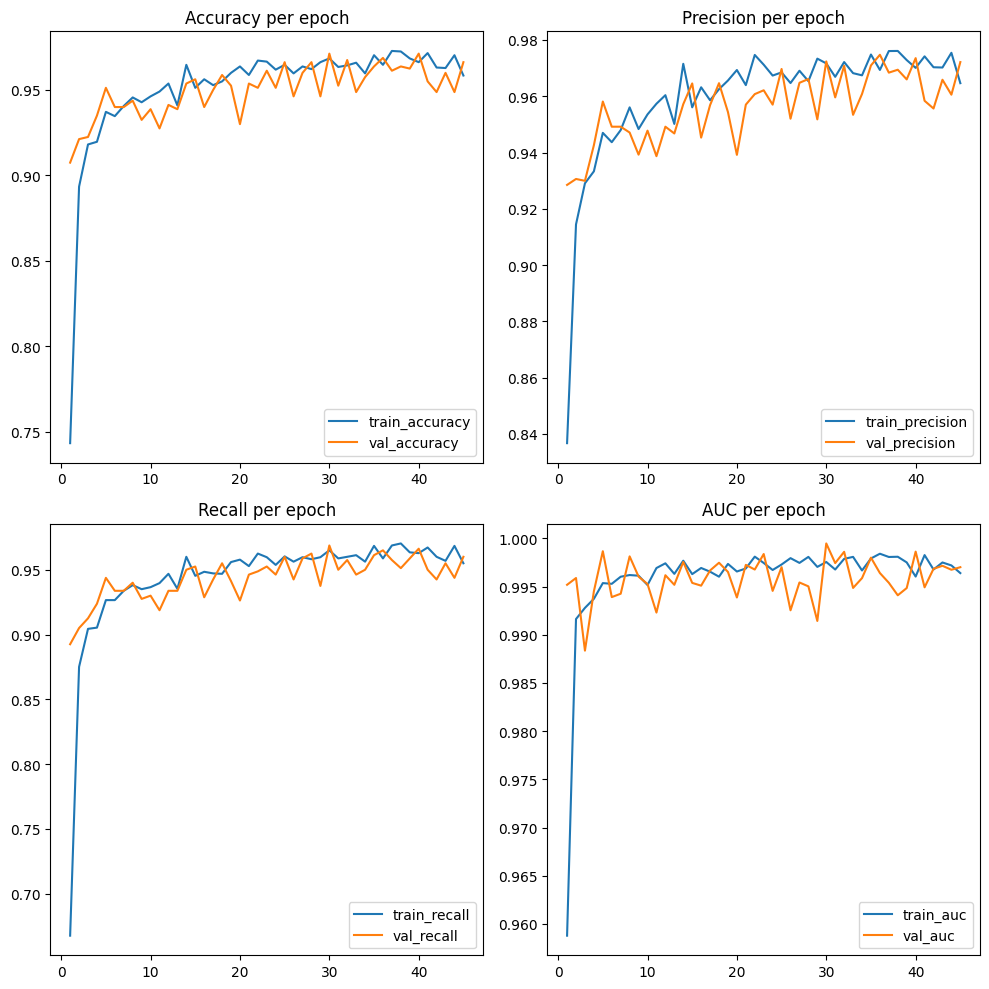

In [10]:
# --- Plot training history (both raw and optional cumulative smoothing) ---
metrics = history.history
epochs_range = range(1, len(metrics['categorical_accuracy']) + 1)

plt.figure(figsize=(10, 10))

# Raw per-epoch accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs_range, metrics['categorical_accuracy'], label='train_accuracy')
plt.plot(epochs_range, metrics.get('val_categorical_accuracy', []), label='val_accuracy')
plt.title('Accuracy per epoch')
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, metrics.get('precision', []), label='train_precision')
plt.plot(epochs_range, metrics.get('val_precision', []), label='val_precision')
plt.title('Precision per epoch')
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, metrics.get('recall', []), label='train_recall')
plt.plot(epochs_range, metrics.get('val_recall', []), label='val_recall')
plt.title('Recall per epoch')
plt.legend(loc='lower right')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, metrics.get('auc', []), label='train_auc')
plt.plot(epochs_range, metrics.get('val_auc', []), label='val_auc')
plt.title('AUC per epoch')
plt.legend(loc='lower right')

plt.tight_layout()
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/disease-detection.png')
plt.show()


In [9]:
# Evaluate
eval_results = model.evaluate(validation_generator)
print("Evaluation:", eval_results)

100/100 [==============================] - 104s 1s/step - loss: 2.0809 - categorical_accuracy: 0.1225 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5483
Evaluation: [2.0809431076049805, 0.12250000238418579, 0.0, 0.0, 0.5482690334320068]


In [12]:
# --- Use sklearn for a per-class report (recommended) ---
# Predict on validation set (ensure shuffle=False above)
val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
y_pred_probs = model.predict(validation_generator, steps=val_steps)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes  # requires shuffle=False

print("Classification report (sklearn):")
print(classification_report(y_true, y_pred, target_names=[index_to_class[i] for i in range(num_classes)]))

100/100 [==============================] - 36s 355ms/step
Classification report (sklearn):
                  precision    recall  f1-score   support

     Anthracnose       0.93      0.91      0.92       100
Bacterial Canker       0.95      1.00      0.98       100
  Cutting Weevil       1.00      0.98      0.99       100
        Die Back       0.99      0.98      0.98       100
      Gall Midge       0.93      0.94      0.94       100
         Healthy       0.96      0.98      0.97       100
  Powdery Mildew       1.00      0.90      0.95       100
     Sooty Mould       0.92      0.98      0.95       100

        accuracy                           0.96       800
       macro avg       0.96      0.96      0.96       800
    weighted avg       0.96      0.96      0.96       800



100/100 [==============================] - 33s 332ms/step


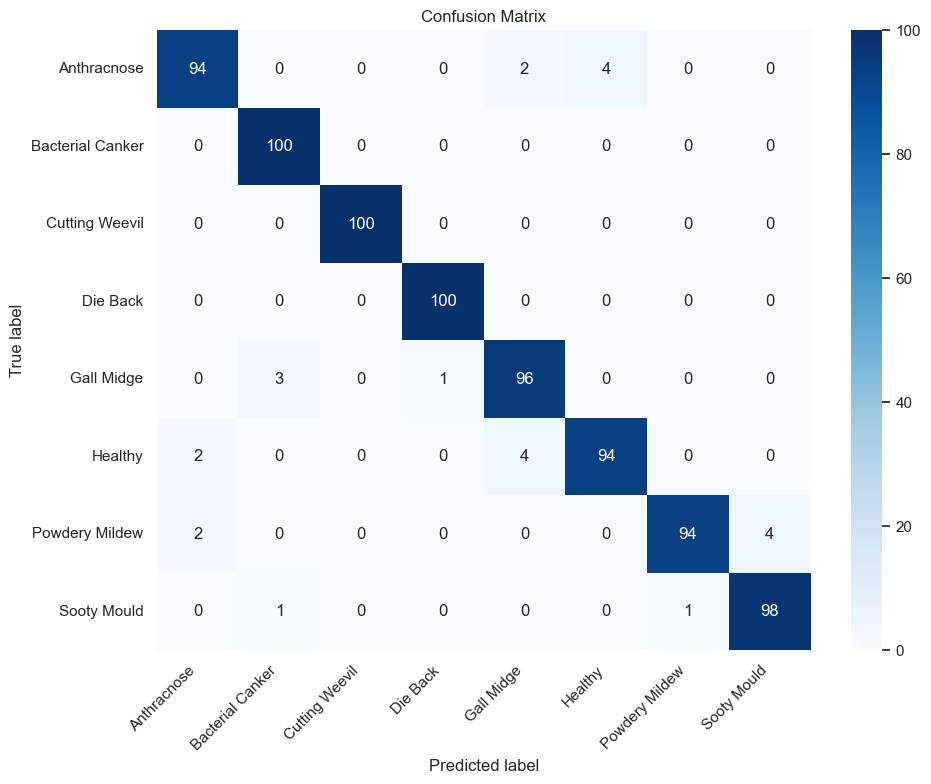

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
y_pred_probs = model.predict(validation_generator, steps=val_steps)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes  # requires shuffle=False

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
num_classes = cm.shape[0]
labels = [index_to_class[i] for i in range(num_classes)]

# Normalized confusion matrix (row-wise: true class proportions)
with np.errstate(all='ignore'):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # replace NaNs (if any class has zero samples) with zeros
    cm_norm = np.nan_to_num(cm_norm)

os.makedirs('plots', exist_ok=True)

# --- Absolute counts heatmap ---
plt.figure(figsize=(10, 8))
sns.set(style='whitegrid')
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    cbar=True
)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/confusion_matrix_counts.png', dpi=200)
plt.show()


#### INFERANCE

In [10]:
def inference_func(image_path, model=model, index_to_class=index_to_class):
    image_path = image_path.replace('\\', '/')
    # parent folder name assumed to be the class when you want to compare; optional
    parent_folder = image_path.split('/')[-2] if '/' in image_path else None

    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_arr = np.array(img).astype(np.float32)
    img_arr = tf.keras.applications.xception.preprocess_input(img_arr)
    img_arr = np.expand_dims(img_arr, axis=0)

    y_pred = model.predict(img_arr)
    pred_idx = int(np.argmax(y_pred, axis=1).squeeze())
    proba = float(np.max(y_pred))
    class_name = index_to_class[pred_idx]

    # Optionally mark low confidence results
    low_confidence = proba < 0.5

    return {
        "predicted_class": class_name,
        "predicted_index": pred_idx,
        "probability": proba,
        "low_confidence": bool(low_confidence),
        "expected_parent_folder": parent_folder
    }

In [12]:
inference_func(r'C:\Users\User\Desktop\PP1\Diseases\Mango_Diseases\dataset\Bacterial Canker\IMG_20211106_120815 (Custom).jpg')

1/1 [==============================] - 2s 2s/step


{'predicted_class': 'Bacterial Canker',
 'predicted_index': 1,
 'probability': 0.2327771782875061,
 'low_confidence': True,
 'expected_parent_folder': 'Bacterial Canker'}